# Bingo Tutorial

## Zero Minimization Problem: Achieve a fitness of 0 for the given population

### Multiple Value Variation
Instantiation of Chromosomes requires a function to return values of a desired type with which to populate their lists of values. In this example, that function is `get_random_float`. Variation amongst a `MultipleValueChromosome` requires single-point crossover and mutation.

In [14]:
import numpy as np

from bingo.Base.MultipleValues import SinglePointCrossover
from bingo.Base.MultipleValues import SinglePointMutation

np.random.seed(0)

def get_random_float():
    return np.random.random_sample()

crossover = SinglePointCrossover()
mutation = SinglePointMutation(get_random_float)

### Chromosome Generator
Individual Chromosomes are created with a Generator. This Generator is initialized with the random value function used to populate their value lists, along with the desired size of the value list, and a list of indices on which to perform local optimization. This Generator is also used to generate populations of Chromosomes on Islands.

In [15]:
from bingo.Base.MultipleFloats import MultipleFloatChromosomeGenerator

VALUE_LIST_SIZE = 8

generator = MultipleFloatChromosomeGenerator(get_random_float, VALUE_LIST_SIZE, [1, 3, 4])

In [16]:
def print_population(population):
    for i, indv in enumerate(population):
            print("indv", i, ["{0:.2f}".format(val) for val in indv.values])

In [17]:
chromosome = generator()
pop = [chromosome]
print_population(pop)
print(pop[0].get_number_local_optimization_params())
print(pop[0].fit_set)

indv 0 ['0.72', '0.60', '0.54', '0.42', '0.65', '0.44', '0.89', '0.96']
3
False


### Fitness and Evaluation
In order to Evaluate Chromosomes and assign them a fitness value, first we must define a `FitnessFunction`. For the Zero Min Problem, this Fitness Function calculates fitness by finding the norm of all the values in a Chromosome's list of values. Once a `FitnessFunction` has been defined, it can be passed to an Evaluation to be applied to a population. In this example, we also wrap the `FitnessFunction` with ContinuousLocalOptimization to perform local optimization on indicies specified in the Generator class.

In [18]:
from bingo.Base.FitnessFunction import FitnessFunction
from bingo.Base.ContinuousLocalOptimization import ContinuousLocalOptimization
from bingo.Base.Evaluation import Evaluation

class ZeroMinFitnessFunction(FitnessFunction):
    def __call__(self, individual):
        return np.linalg.norm(individual.values)

                              
fitness = ZeroMinFitnessFunction()
local_opt_fitness = ContinuousLocalOptimization(fitness)
evaluator = Evaluation(local_opt_fitness)

In [19]:
evaluator(pop)
print(pop[0].fit_set)
print(pop[0].fitness)
print_population(pop)

True
1.6503881607810404
indv 0 ['0.72', '0.00', '0.54', '0.00', '-0.00', '0.44', '0.89', '0.96']


### Selection
For this example, we use Tournament Selection to select `GOAL_POPULATION_SIZE` most fit individuals to advance to the next generation.

In [20]:
from bingo.Base.TournamentSelection import Tournament

GOAL_POPULATION_SIZE = 25

selection = Tournament(GOAL_POPULATION_SIZE)

### Evolutionary Algorithm: Mu + Lambda
The Evolutionary Algorithm used in this example is called `MuPlusLambda`. Mu represents the parent population and Lambda represents their offspring. MuPlusLambda means the parents and offspring are evaluated together and then the most fit individuals for the next generation are selected from both populations combined. We pass our previously defined Evaluation and Selection modules to MuPlusLambda, along with Crossover and Mutation which will be used to define the behaviors of Variation.

In [21]:
from bingo.Base.MuPlusLambdaEA import MuPlusLambda

MUTATION_PROBABILITY = 0.4
CROSSOVER_PROBABILITY = 0.4
NUM_OFFSPRING = GOAL_POPULATION_SIZE

evo_alg = MuPlusLambda(evaluator,
                       selection,
                       crossover,
                       mutation,
                       CROSSOVER_PROBABILITY,
                       MUTATION_PROBABILITY,
                       NUM_OFFSPRING)

### Island
The `Island` class takes as arguments the Evolutionary Algorithm defined previously, along with the Generator with which to generate an initial population of size `POPULATION_SIZE`. The `Island` will create a population and then execute generational steps of the Evolutionary Algorithm to evolve the population.

In [22]:
from bingo.Base.Island import Island

POPULATION_SIZE = 25
np.random.seed(0)
island = Island(evo_alg, generator, POPULATION_SIZE)

In [23]:
print_population(island.population)

indv 0 ['0.55', '0.72', '0.60', '0.54', '0.42', '0.65', '0.44', '0.89']
indv 1 ['0.96', '0.38', '0.79', '0.53', '0.57', '0.93', '0.07', '0.09']
indv 2 ['0.02', '0.83', '0.78', '0.87', '0.98', '0.80', '0.46', '0.78']
indv 3 ['0.12', '0.64', '0.14', '0.94', '0.52', '0.41', '0.26', '0.77']
indv 4 ['0.46', '0.57', '0.02', '0.62', '0.61', '0.62', '0.94', '0.68']
indv 5 ['0.36', '0.44', '0.70', '0.06', '0.67', '0.67', '0.21', '0.13']
indv 6 ['0.32', '0.36', '0.57', '0.44', '0.99', '0.10', '0.21', '0.16']
indv 7 ['0.65', '0.25', '0.47', '0.24', '0.16', '0.11', '0.66', '0.14']
indv 8 ['0.20', '0.37', '0.82', '0.10', '0.84', '0.10', '0.98', '0.47']
indv 9 ['0.98', '0.60', '0.74', '0.04', '0.28', '0.12', '0.30', '0.12']
indv 10 ['0.32', '0.41', '0.06', '0.69', '0.57', '0.27', '0.52', '0.09']
indv 11 ['0.58', '0.93', '0.32', '0.67', '0.13', '0.72', '0.29', '0.18']
indv 12 ['0.59', '0.02', '0.83', '0.00', '0.68', '0.27', '0.74', '0.96']
indv 13 ['0.25', '0.58', '0.59', '0.57', '0.22', '0.95', '0.4

In [24]:
best_indv_values = []
best_indv_values.append(island.best_individual().values)
for i in range(50):
    island.execute_generational_step()
    best_indv_values.append(island.best_individual().values)

### Animation of Evolutionary Algorithm

In [25]:
from IPython.display import HTML

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def animate_data(list_of_best_indv_values):

    fig, ax = plt.subplots()

    num_generations = len(list_of_best_indv_values)
    x = np.arange(0, len(list_of_best_indv_values[0]))
    y = list_of_best_indv_values
    zero = [0]*len(x)
    polygon = ax.fill_between(x, zero, y[0], color='b', alpha=0.3)
    points, = ax.plot(x, y[0], 'bs')
    points.set_label('Generation :' + str(0))
    legend = ax.legend(loc='upper right', shadow=True)


    def animate(i):
        ax.collections.clear()
        polygon = ax.fill_between(x, zero, y[i], color='b', alpha=0.3)
        points.set_ydata(y[i])  # update the data
        points.set_label('Generation :' + str(i))
        legend = ax.legend(loc='upper right')
        return points, polygon, legend


    # Init only required for blitting to give a clean slate.
    def init():
        points.set_ydata(np.ma.array(x, mask=True))
        return points, polygon, points

    plt.xlabel('Chromosome Value Index', fontsize=15)
    plt.ylabel('Value Magnitude', fontsize=15)
    plt.title("Values of Best Individual in Island", fontsize=15)
    plt.ylim(-0.01,2.05)
    ax.tick_params(axis='y', labelsize=15)
    ax.tick_params(axis='x', labelsize=15)

    return animation.FuncAnimation(fig, animate, num_generations, init_func=init,
                                interval=250, blit=True)

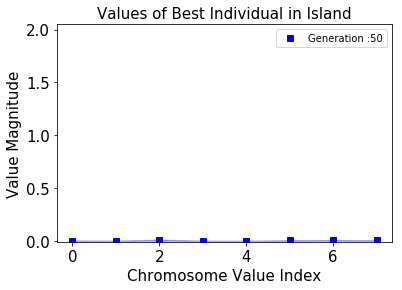

In [26]:
from IPython.display import HTML
HTML(animate_data(best_indv_values).to_html5_video())